In [ ]:
# 感谢古镇天为代码指正错误

import math
import numpy as np #基础库科学运算
import matplotlib.pyplot as plt # 画图
from matplotlib.ticker import MultipleLocator
import pandas as pd # 导出表格

# 1.1 条件参数
时间表 = list(range(100, 1+72000*4, 1)) # 时间数组，从1~72000tick遍历一遍每个时间节点的数据，也可以改成[12000,24000,36000]之类的需要的时间节点
产量放大系数 = 72000 # 算出来的数据(仅效率类，不包含产量)时间单位都是tick，所以数值非常小，可以放大72000倍得到每小时的效率(不放大填1)

age_first = 0 # 第一个age
age_last = 4 # 最后一个age
age_count = age_last - age_first + 1 # 自动计算age的个数

age_product = age_count * [0] # 初始化产量表
age_product[-1] = 1 # 最后一个阶段被收割的产量

p = 1/5/6 # 每个age进入下一个阶段的概率
p_list = (age_count) * [p] # 每个age的p代表进入下一个阶段的概率
p_list[-1] = 0 # 最后一个age的p填1，代表已经成熟，不会再变

收割起始age列表 = [0] # 可多填，每个数字代表每种情况下从哪个age开始都会被收割，例如[0, -1]代表分别算出全部收割和只精准的收割最后一个age的两种效率的不同
收割次数表 = [1] # 可多填，例如[1,2,3,4,5,10,10000]表示画出收割1、2、3...次的收割时数据，较大的数字(10000)可模拟长时间后的稳态
收割费时 = 2 # 收割造成的无法生长的时间

# 1.2 输出参数
图片边长像素 = 2160 # 单个图像的像素大小(边长)，这三个图像会拼成一个整图输出
绘制曲线age表 = ["all"] # 绘制曲线的age列表：["all"]全部画出；[1, 2, -1]画出age为1,2和最后的情况的曲线
标记极值的tick_min = 100 # 前100tick概率较小容易出现浮点数误差造成抖动而倍当做极值
标记极值的tick_max = max(时间表)



# 2.初始化与计算

# 2.1.1 初始状态矩阵 A
A = np.zeros(age_count)
A[0] = 1 # 初始状态下全部位于第一个阶段

# 2.1.2 状态转移矩阵 T
P = np.zeros((age_count, age_count))
for i in range(age_count):
    P[i, i] = 1 - p_list[i]/4096
for i in range(age_count - 1):
    P[i, i + 1] = p_list[i]/4096

# 2.2 计算
age_list = list(range(0,age_count)) # age的列表，从0到age_count-1
收割起始age列表 = [age_count - 1 if age == -1 else age for age in 收割起始age列表] # 将列表里的-1(表示最后一个age)替换为age_count-1

单位产量表 = []
单位效率表 = []
for harvest_age in 收割起始age列表:
    # 收割矩阵 H
    H = np.zeros((age_count, age_count))
    for i in range(0, harvest_age): # 不收割的
        H[i, i] = 1
    for i in range(harvest_age, age_count): # 收割的
        H[i, 0] = 1
    
    # 作物产量矩阵 A
    单位产量表_收割age = []
    单位效率表_收割age = []
    for harvested in 收割次数表:
        单位产量表_收割age_收割轮数 = []
        单位效率表_收割age_收割轮数 = []
        for t in 时间表:
            Pt = np.linalg.matrix_power(P, 3*t)
            S = A @ np.linalg.matrix_power(Pt @ H, harvested - 1) @ Pt
            S = np.append(S, S @ age_product) # S最后增加一列为产量
            单位产量表_收割age_收割轮数.append(S.tolist())
            单位效率表_收割age_收割轮数.append((产量放大系数 * S / (t + 收割费时)).tolist())
            # 这两个表格是第一层为不同时间，第二层为不同age，这个顺序不方便画图，所以最后要转置一下(zip(*))
        单位产量表_收割age.append([list(i) for i in zip(*单位产量表_收割age_收割轮数)])
        单位效率表_收割age.append([list(j) for j in zip(*单位效率表_收割age_收割轮数)])
    单位产量表.append(单位产量表_收割age)
    单位效率表.append(单位效率表_收割age)
print("全部数据计算完成")


全部数据计算完成


绘制曲线age表: [0, 1, 2, 3, 4]


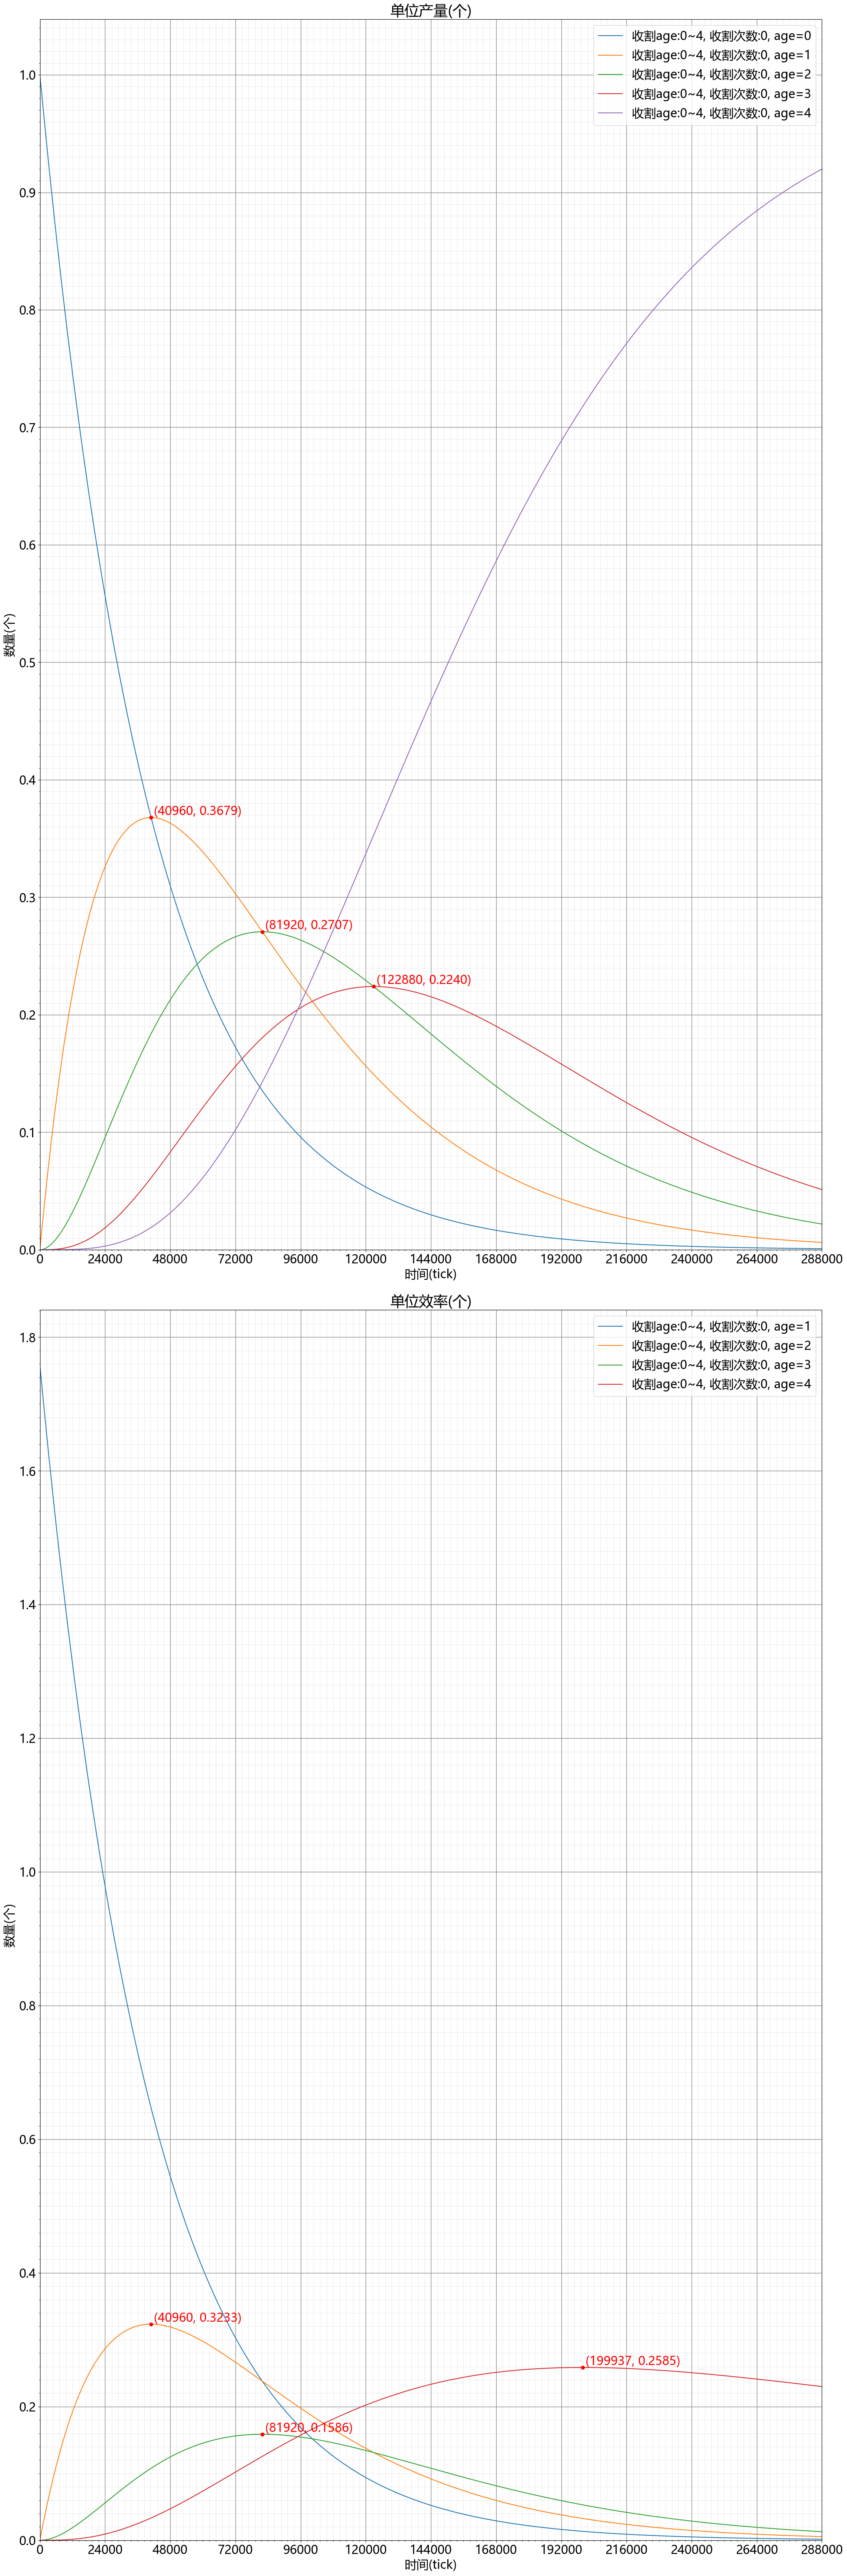

数据已画图导出为图像


In [ ]:
# 3. 画图

# 3.1.1 找极值点函数
def find_extrema(data, rel_tol=1e-16):
    extrema_indices = []
    for i in range(1, len(data) - 1): # 遍历数据，跳过第一个和最后一个元素，因为它们没有足够的邻值进行比较
        if not math.isclose(data[i], data[i - 1], rel_tol=rel_tol) and \
        not math.isclose(data[i], data[i + 1], rel_tol=rel_tol):# 检查当前值与相邻值的接近性
            if (data[i] > data[i - 1] and data[i] > data[i + 1]) or \
            (data[i] < data[i - 1] and data[i] < data[i + 1]): # 判断是否为极值点
                extrema_indices.append(i)
    return extrema_indices # 返回极值点的data索引列表

# 3.1.2 # 计算最合适的坐标系网格的固定间隔
def get_ideal_interval(range_value, target_lines, factor_list):
    ideal_interval = range_value / target_lines # 计算理想间隔
    order_of_magnitude = 10 ** int(np.floor(np.log10(ideal_interval))) # 计算理想间隔的数量级(为10的幂次)
    order_of_magnitude_expand = [order_of_magnitude / 10, order_of_magnitude, order_of_magnitude * 10] # 扩展数量级范围(增加*10与/10)
    best_interval = None # 初始化最佳间隔为None
    min_difference = float('inf') # 初始化最小差值为正无穷大
    for power in order_of_magnitude_expand:
        for factor in factor_list: # 遍历三个数量级下的 1, 2, 5 倍数候选
            interval = factor * power
            grid_count = range_value / interval # 计算该间隔的划分数
            difference = abs(grid_count - target_lines)
            if difference < min_difference: # 更新找到的最接目标近划分数的间隔
                min_difference = difference
                best_interval = interval
    return best_interval

# 3.1.3 画图设置函数
def plot_set(ax, title, xlabel, ylabel):
    x_min, x_max = 0, max(时间表)
    y_min, y_max = float('inf'), float('-inf')
    for line in ax.lines:
        y_data = line.get_ydata()
        y_min = min(y_min, min(y_data))
        y_max = max(y_max, max(y_data))
    y_min_0 = 0 if y_min >= 0 else None # 如果y_min不是负数，则从原点开始画图，否则None即自动判断
    x_interval = get_ideal_interval(x_max - x_min, 12 ,[1.2, 2.4, 6.0]) # 1分钟，2分钟，5分钟
    y_interval = get_ideal_interval(y_max - y_min_0, 12 ,[1,2,5])
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, max(时间表))
    ax.set_ylim(y_min_0, None)
    ax.xaxis.set_major_locator(MultipleLocator(x_interval))
    ax.xaxis.set_minor_locator(MultipleLocator(x_interval/10))
    ax.yaxis.set_major_locator(MultipleLocator(y_interval))
    ax.yaxis.set_minor_locator(MultipleLocator(y_interval/10))
    ax.grid(which='major', axis='x', linestyle='-', linewidth=1, color='#888888')
    ax.grid(which='minor', axis='x', linestyle=':', linewidth=0.5, color='#aaaaaa')
    ax.grid(which='major', axis='y', linestyle='-', linewidth=1, color='#888888')
    ax.grid(which='minor', axis='y', linestyle=':', linewidth=0.5, color='#aaaaaa')
    ax.legend()

# 3.1.4 画图函数
def plot_data(ax, data, harvest_age, harvested_times, current_age, 是否标记极值点):
    ax.plot(时间表, data, label=f'收割age:{harvest_age}~{age_count-1}, 收割次数:{harvested_times}, age={current_age}')

    if 是否标记极值点: # 标记极值点
        extrema_indices = find_extrema(data)
        for idx in extrema_indices:
            if 标记极值的tick_min <= 时间表[idx] <= 标记极值的tick_max:
                ax.scatter(时间表[idx], data[idx], color='red', zorder=5)
                ax.annotate(f'({时间表[idx]}, {data[idx]:.4f})',
                            xy=(时间表[idx], data[idx]),
                            xytext=(5, 5), textcoords='offset points', fontsize=picture_inch_size, color='red')

# 3.2 画图
picture_inch_size = 图片边长像素 / 100  # matplotlib使用英寸参数，DPI默认为100，也就是1英寸=100像素
plt.rcParams['font.family'] = 'Microsoft YaHei'  # 字体设置，确保中英文都支持
plt.rcParams['font.size'] = picture_inch_size  # 字体尺寸
fig, axs = plt.subplots(2, 1, figsize=(picture_inch_size, 3 * picture_inch_size))
绘制曲线age表 = [age_count - 1 if age == -1 else age for age in 绘制曲线age表] # 将列表里的-1(表示最后一个age)替换为age_count-1
if "all" in 绘制曲线age表: 绘制曲线age表 = list(range(age_first, age_last+1))  # 如果绘制曲线age表包含all，则绘制所有age

# 画产量图
for harvest_age_idx, harvest_age in enumerate(收割起始age列表):
    for harvested_times_idx, harvested_times in enumerate(收割次数表):
        for current_age_idx, current_age in enumerate(age_list):
            if current_age in 绘制曲线age表:
                plot_data(axs[0], 单位产量表[harvest_age_idx][harvested_times_idx][current_age_idx], harvest_age, harvested_times, current_age, True)
plot_set(axs[0], '单位产量(个)', '时间(tick)', '数量(个)')

for harvest_age_idx, harvest_age in enumerate(收割起始age列表):
    for harvested_times_idx, harvested_times in enumerate(收割次数表):
        for current_age_idx, current_age in enumerate(age_list):
            if current_age in 绘制曲线age表 and current_age != 0: # 不画age=0的曲线，因为这相当于“不成长的效率”，不仅数值极大且无用
                plot_data(axs[1], 单位效率表[harvest_age_idx][harvested_times_idx][current_age_idx], harvest_age, harvested_times, current_age, True)
plot_set(axs[1], '单位效率(个)', '时间(tick)', '数量(个)')

# 3.3 绘制图像并导出
plt.tight_layout()
plt.savefig(f'数据图像(收割费时{收割费时}t).png', dpi=100, bbox_inches='tight')
plt.show()
print("数据已画图导出为图像")


In [ ]:
# 4 数据导出到Excel表格

# 4.1 添加数据的函数
def export_to_excel(sheet_name, data_table):
    all_data = []  # 存储最终数据

    # 初始化列数，横向拼接时需要对每个组合逐列添加
    max_rows = len(时间表) + 2  # 包含标题行和空行
    combined_data = [[] for _ in range(max_rows)]  # 每一行为一个列表

    for i, harvest_age in enumerate(收割起始age列表):  # 遍历每个收割age
        for j, harvest_round in enumerate(收割次数表):  # 遍历每个收割次数
            # 创建标题行
            header_row = [f"时间(收割age:{harvest_age}&次数:{harvest_round})"] + [f"age={age}" for age in age_list]

            # 添加数据行
            for t_idx, t in enumerate(时间表):
                row_data = [t] + [data_table[i][j][a_idx][t_idx] for a_idx in range(len(age_list))]

                # 插入到对应的行中
                combined_data[t_idx + 1].extend(row_data + [''])  # 数据行后添加空列分隔

            # 插入标题行
            combined_data[0].extend(header_row + [''])  # 标题行后添加空列分隔

            # 插入空行（在最后用于分隔）
            combined_data[-1].extend([''] * len(header_row) + [''])

    # 转换为 DataFrame 并导出
    df = pd.DataFrame(combined_data)
    df.to_excel(writer, sheet_name=sheet_name, index=False, header=False)

# 4.2 使用 ExcelWriter 导出数据
with pd.ExcelWriter(f"数据表(收割费时{收割费时}t).xlsx", engine="openpyxl") as writer:
    # 导出单位产量
    export_to_excel("单位产量", 单位产量表)
    # 导出单位效率
    export_to_excel("单位效率", 单位效率表)

    # 设置列宽和冻结窗格
    column_width = 16
    for sheet_name in ["单位产量", "单位效率"]:
        worksheet = writer.sheets[sheet_name]
        worksheet.freeze_panes = "A2"  # 冻结窗格
        for column_cells in worksheet.columns:  # 设置列宽
            column_letter = column_cells[0].column_letter
            worksheet.column_dimensions[column_letter].width = column_width

print("数据已导出为Excel表格")


数据已导出为Excel表格
